# Trajectories analysis 3 (collective behaviour)
This notebook shows different analysis routines for trajectories of groups extracted with [idtracker.ai](idtracker.ai). If you use this code and/or data generated with [idtracker.ai](idtracker.ai), please cite:

**Romero-Ferrero, F., Bergomi, M.G., Hinz, R.C., Heras, F.J.H., de Polavieja, G.G., Nature Methods, 2019. idtracker.ai: tracking all individuals in small or large collectives of unmarked animals (F.R.-F. and M.G.B. contributed equally to this work. Correspondence should be addressed to G.G.d.P: gonzalo.polavieja@neuro.fchampalimaud.org)**

Some of the methods in this script are also available as part of a Matlab toolkit, idSocial (http://www.idtracker.es/idsocial) that was used and developed for the analysis of the article

**Hinz, R. C., & de Polavieja, G. G. (2017). Ontogeny of collective behavior reveals a simple attraction rule. Proceedings of the National Academy of Sciences, 201616926.** 

To load and analyse the trajectories we will be using the python library *trajectorytools*, you can install with `pip install trajectorytools`. If you use it, please cite:

**Heras, F. J. H., Romero-Ferrero, F., Hinz, R. C., & de Polavieja, G. G. (2019). Deep attention networks reveal the rules of collective motion in zebrafish. PLoS computational biology, 15(9), e1007354.**

## Importing necessary python modules for our analysis

In [1]:
import os
from pprint import pprint
import numpy as np
from scipy import stats
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# trajectorytools needs to be installed. To install, 
# pip install trajectorytools or follow the instructions at
# http://www.github.com/fjhheras/trajectorytools
import trajectorytools as tt
import trajectorytools.plot as ttplot
import trajectorytools.socialcontext as ttsocial

## Load trajectories and setting parameters

Check the notebook T0_loading_idtrackerai_trajectories for more detailed instructions about loading idtracker.ai trajectories.

In [2]:
# Set path where to load trajectories from
trajectories_path = '../data/trajectories_wo_gaps.npy'
tr = tt.Trajectories.from_idtrackerai(trajectories_path, 
                                      interpolate_nans=True,
                                      smooth_params={'sigma': 1})
# Since the arena of the setup was circular and the fish visited the borders of the arena
# we use the estimate_center_and_radius_from_locations to center the trajectories
# in the arena
center, radius = tr.estimate_center_and_radius_from_locations(in_px=True)
tr.origin_to(center)
# In our case we know that the body_length_px is a good estimate for the body length
# since we loaded the trajectories with the method from_idtrackerai this value is 
# stored in the tr.params disctionary
tr.new_length_unit(tr.params['body_length_px'], 'BL')
# Since we loaded the trajectories with the method from_idtrackerai we can 
# use the frame_rate variable stored in the tr.params disctioanry to
# to set the time units to seconds
print('Positions:')
print('X range:', np.nanmin(tr.s[...,0]), np.nanmax(tr.s[...,0]), 'BL')
print('Y range:', np.nanmin(tr.s[...,1]), np.nanmax(tr.s[...,1]), 'BL')
print('Velcities:')
print('X range:', np.nanmin(tr.v[...,0]), np.nanmax(tr.v[...,0]), 'BL/s')
print('Y range:', np.nanmin(tr.v[...,1]), np.nanmax(tr.v[...,1]), 'BL/s')
print('Accelerations:')
print('X range:', np.nanmin(tr.a[...,0]), np.nanmax(tr.a[...,0]), 'BL/s^2')
print('Y range:', np.nanmin(tr.a[...,1]), np.nanmax(tr.a[...,1]), 'BL/s^2')
pprint(tr.params)

Positions:
X range: -22.857960805634484 23.004886491518306 BL
Y range: -23.15551579252565 23.09623793320273 BL
Velcities:
X range: -0.7596434737145985 0.7950006518282955 BL/s
Y range: -0.8513883870094342 0.6596325996572823 BL/s
Accelerations:
X range: -0.5666745960720289 1.1746444912628775 BL/s^2
Y range: -0.366798301338635 0.338334734197512 BL/s^2
{'_center': array([1782.57651696, 1761.71033149]),
 'body_length_px': 69.0,
 'construct_method': 'from_idtrackerai',
 'displacement': array([-1782.57651696, -1761.71033149]),
 'frame_rate': 32,
 'interpolate_nans': True,
 'length_unit': 69.0,
 'length_unit_name': 'BL',
 'path': '../data/trajectories_wo_gaps.npy',
 'radius': 23.18884521417357,
 'radius_px': 1600.0303197779763,
 'smooth_params': {'sigma': 1},
 'time_unit': 1,
 'time_unit_name': 'frames'}


## Global group behavior

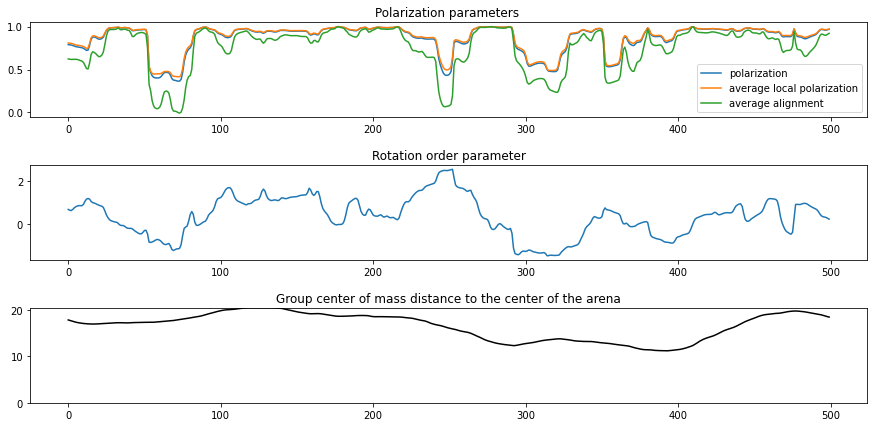

In [3]:
def get_average_local_polarization(t, number_of_neighbours = 3):
    indices = ttsocial.neighbour_indices(t.s, number_of_neighbours)
    en = ttsocial.restrict(t.e,indices)[...,1:,:]
    local_polarization = tt.norm(tt.collective.polarization(en))
    return np.nanmean(local_polarization, axis = -1)

def get_average_aligment_score(t, number_of_neighbours = 3):
    indices = ttsocial.neighbour_indices(t.s, number_of_neighbours)
    en = ttsocial.restrict(t.e,indices)[...,1:,:]
    alignment = np.nanmean(tt.dot(np.expand_dims(t.e,2), en), axis = -1)
    return np.nanmedian(alignment, axis = -1)

t=tr[0:500]
polarization_order_parameter = tt.norm(tt.collective.polarization(t.e))
average_local_polarization = get_average_local_polarization(t)
average_alignment = get_average_aligment_score(t)
fig, ax_arr = plt.subplots(3,1,figsize=(15,7))

ax = ax_arr[0]
ax.set_title('Polarization parameters ')
ax.plot(polarization_order_parameter, label = 'polarization')
ax.plot(average_local_polarization, label = 'average local polarization')
ax.plot(average_alignment, label = 'average alignment')
ax.legend()

ax = ax_arr[1]
ax.set_title('Rotation order parameter')
rotation_order_parameter = tt.collective.angular_momentum(t.e, t.s, center = t.center_of_mass.s) / t.number_of_individuals
ax.plot(rotation_order_parameter)

ax = ax_arr[2]
ax.set_title('Group center of mass distance to the center of the arena')
ax.plot(t.center_of_mass.distance_to_origin, color = 'k')
ax.set_ylim((0, np.max(t.center_of_mass.distance_to_origin)))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=.5)

Text(0, 0.5, 'Polarization order parameter')

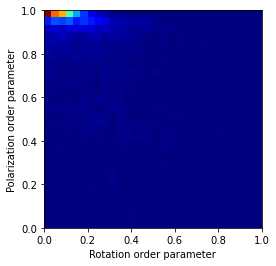

In [4]:
t=tr[0:10000]
polarization_order_parameter = tt.norm(tt.collective.polarization(t.e))
rotation_order_parameter = tt.collective.angular_momentum(t.e, t.s, center = t.center_of_mass.s) / t.number_of_individuals
fig, ax = plt.subplots(1)
H, _, _ = np.histogram2d(polarization_order_parameter[~np.isnan(polarization_order_parameter)], np.abs(rotation_order_parameter[~np.isnan(polarization_order_parameter)]), bins=(30, 30))
im = ax.imshow(H, cmap = 'jet', extent=(0, 1, 1, 0))
ax.invert_yaxis()
ax.set_xlabel('Rotation order parameter')
ax.set_ylabel('Polarization order parameter')

## Relative neighbour positions

In a coordinate system in which the focal individual is at the center and moving in direction of the positive y-axis, we can analyse the probability of finding neighbors at certain relative positions, and how the focal individual reacts in terms of left/right turns and increase/decrease in speed. 


In [5]:
# Rotate neighbor positions and acceleration vectors to the focal system:
s_rotated = np.empty((tr.number_of_frames, tr.number_of_individuals, tr.number_of_individuals, 2))
a_rotated = tt.fixed_to_comoving(tr.a,tr.e)

for focal in range(tr.number_of_individuals):
    s = tt.center_in_individual(tr.s,focal)
    sr = tt.fixed_to_comoving(s,tr.e[:,focal,:]) 
    sr[:,focal] = np.nan # Change rotated positions of the focal itself from '0' to 'NaN'. 
    s_rotated[:,focal,:,:] = sr
    a_rotated[:,focal,:] = tt.fixed_to_comoving(tr.a[:,focal],tr.e[:,focal]) # Rotate the focal's 
    # acceleration vector. The x-component of the rotated vector contains the acceleration perpendicular to the
    # focal's direction of movement ('turning'), the parallel component contains the increase/decrease of speed.
    
# Pool together relative neighbor positions and focal acceleration vectors
sr_flat = s_rotated.reshape((-1,1,2))
ar_flat = np.repeat(a_rotated[:,:,np.newaxis,:],tr.number_of_individuals,2).reshape((-1,1,2))

### 2D-Histogram, all focal-neighbour pairs pooled together 

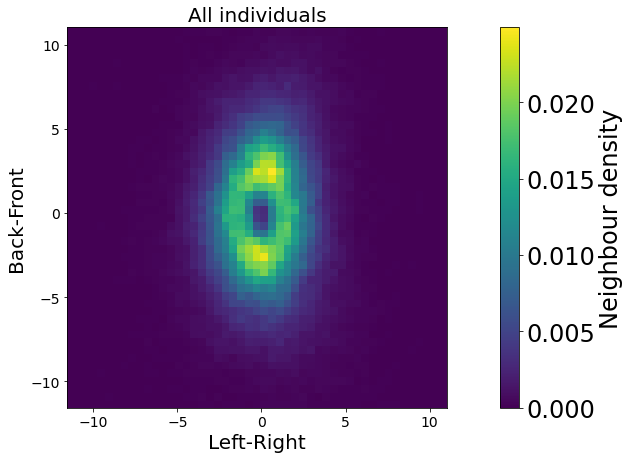

In [6]:
# Define bin edges: (left/bottom limit, right/top limit, bin width)
h_min = np.min([np.nanmin(tr.s[...,0])/2, np.nanmin(tr.s[...,1])/2])
h_max = np.min([np.nanmax(tr.s[...,0])/2, np.nanmax(tr.s[...,1])/2])
bin_size = (h_max - h_min)/50
bins = [np.arange(h_min, h_max, bin_size),np.arange(h_min, h_max, bin_size)] 
x = sr_flat[:,0,0]
y = sr_flat[:,0,1] 

# Clean data from 'Nans'
y = y[~np.isnan(x)]
x = x[~np.isnan(x)]

# Plot the histogram
H, yedges, xedges = np.histogram2d(y,x,bins = bins,normed = True) # x and y are switched to comply with np.histogram2d convention
Y, X = np.meshgrid(yedges, xedges)
fig, ax_meanposmap = plt.subplots(figsize=(19,7))
im = ax_meanposmap.pcolormesh(Y, X, H)

# Add colorbar, labels, etc.
ax_cb = fig.colorbar(im, ax=ax_meanposmap)
ax_meanposmap.set_aspect('equal','box')
ax_meanposmap.set_title('All individuals',fontsize=20);
ax_meanposmap.set_xlabel('Left-Right',fontsize = 20)
ax_meanposmap.set_ylabel('Back-Front',fontsize = 20)
ax_meanposmap.tick_params(labelsize=14)
ax_cb.ax.tick_params(labelsize=24)
ax_cb.set_label('Neighbour density',fontsize=24)


## Polar 2D-histograms and maps of turning and acceleration maps depending on neighbor positions

Keeping only finite values in <function polar_histogram at 0x7fd599e6fdd0> input
Keeping only finite values in <function binned_statistic_polar at 0x7fd599e6fcb0> input
Keeping only finite values in <function binned_statistic_polar at 0x7fd599e6fcb0> input


Text(0.5, 1.05, 'Tangential acc')

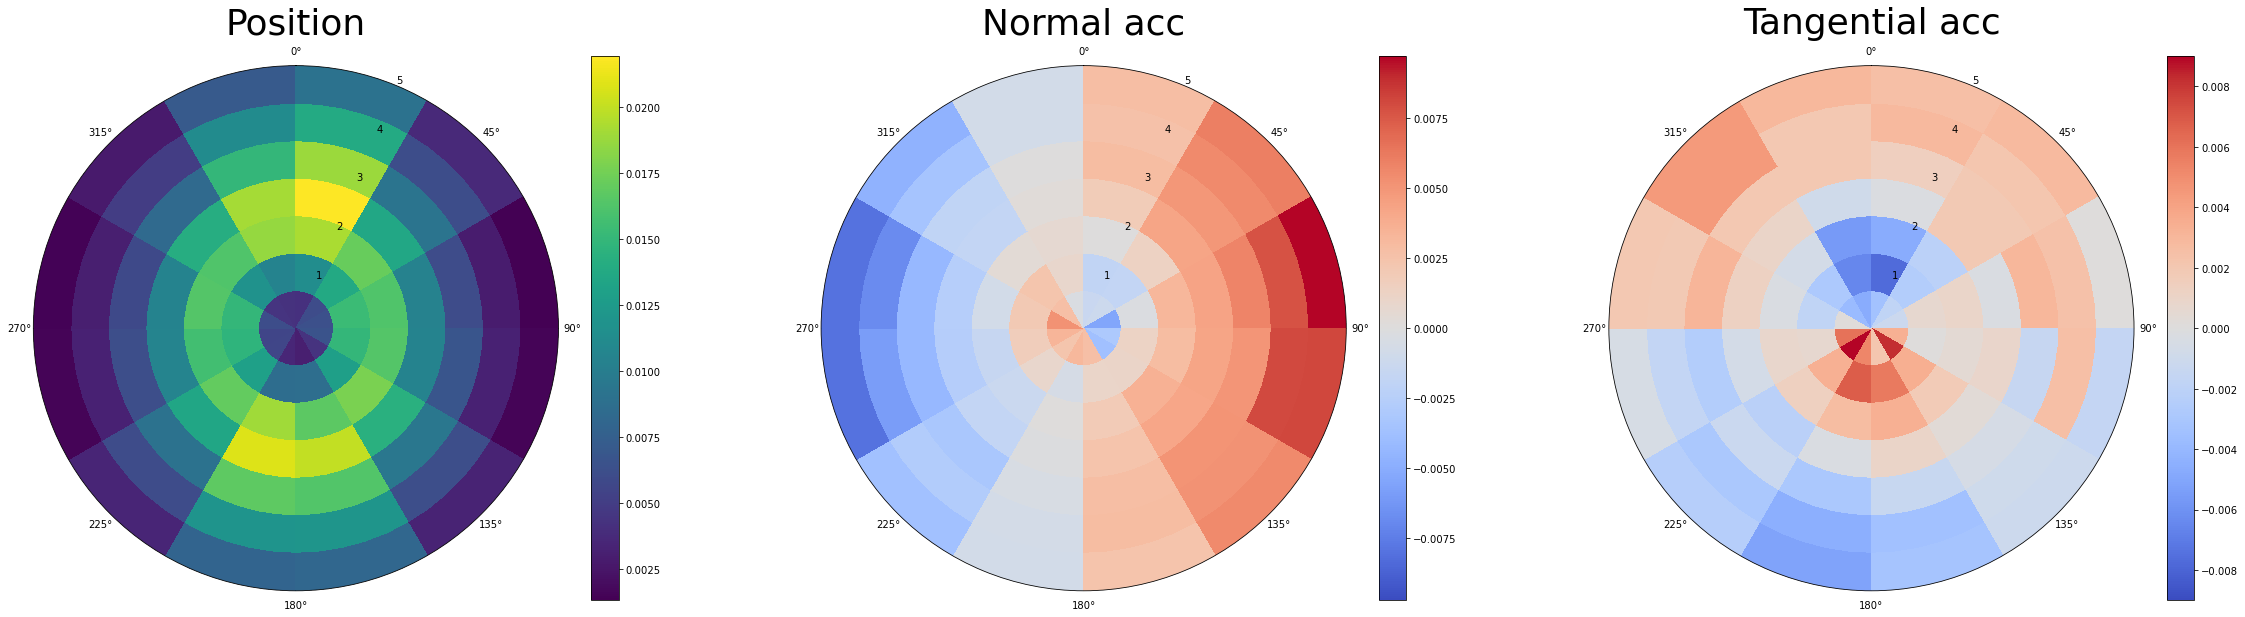

In [7]:
from trajectorytools.plot import (
    polar_histogram,
    binned_statistic_polar,
    plot_polar_histogram,
)

map_value = ar_flat[:, 0, :]
x = sr_flat[:, 0, 0]
y = sr_flat[:, 0, 1]

r = np.sqrt(x ** 2 + y ** 2)
# angles increase clockwise, and are zero in the positive y axis
theta = np.arctan2(x, y) 

pos_hist, r_edges, theta_edges = polar_histogram(r, theta, density=True, range_r=5)
Turn = binned_statistic_polar(r, theta, map_value[:, 0], statistic=np.nanmean, range_r=5)
turn_stats = Turn.statistic

Fwd = binned_statistic_polar(r, theta, map_value[:, 1], statistic=np.nanmean, range_r=5)
fwd_stats = Fwd.statistic

figure(num=None, figsize=(40, 10), facecolor="w", edgecolor="k")
# Plot polar histogram/maps for relative neighbor positions, turning and acceleration

ax = plt.subplot(131, polar=True)
plot_polar_histogram(pos_hist, r_edges, theta_edges, ax,)
ax.set_title("Position", fontsize=36)

cmap_acc = plt.get_cmap("coolwarm")
ax = plt.subplot(132, polar=True)
plot_polar_histogram(turn_stats, r_edges, theta_edges, ax, cmap=cmap_acc, symmetric_color_limits=True)
ax.set_title("Normal acc", fontsize=36)

ax = plt.subplot(133, polar=True)
plot_polar_histogram(fwd_stats, r_edges, theta_edges, ax, cmap=cmap_acc, symmetric_color_limits=True)
ax.set_title("Tangential acc", fontsize=36)


## Inter-Individual Distances

### Calculate interindividual distances

In [8]:
def interindividual_distance(trajectories):
    amatrix = ttsocial.adjacency_matrix(trajectories, mode='distance')
    for i in range(amatrix.shape[1]):
        amatrix[:,i,i] = np.nan
    return amatrix

distances = interindividual_distance(tr.s).reshape((-1,tr.number_of_individuals))

### Generate shuffled trajectories and control distances

In [9]:
def shuffle_trajectories(trajectories, focal=None):
    num_fish = trajectories.shape[1]
    neighbor_idces = [i for i in range(num_fish) if i != focal]
    #print(neighbor_idces)
    t_shuffle = trajectories.copy()
    t_shuffle[:,neighbor_idces] = np.random.permutation(t_shuffle[:,neighbor_idces])
    return t_shuffle

def distance_to_focal(trajectories, focal=None):
    num_fish = trajectories.shape[1]
    distances = np.sqrt(np.sum((trajectories[:,[focal]] - np.delete(trajectories, focal, axis=1) )**2, axis=2))
    return distances #np.delete(distances, focal, axis=1)

# Calculate control data: For each focal individual, shuffle the neighbor positions, then
# calculate the distance between the original focal positions and the randomized neighbor positions.
distances_shuffled = np.empty((tr.number_of_frames*(tr.number_of_individuals-1),tr.number_of_individuals))
for focal in range(tr.number_of_individuals):
    t_shuffle = shuffle_trajectories(tr.s, focal)
    d_ = distance_to_focal(t_shuffle, focal)
    distances_shuffled[:,focal] = d_[:,:].reshape(-1) # Pool all neighbor distances for 'focal'

### Plot distance histograms

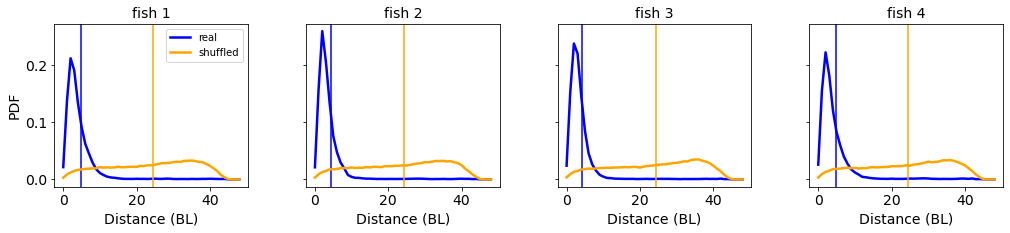

In [10]:
# Mean inter-individual distance to all neighbor animals for each focal.  

def plot_histogram_and_mean(data, ax, color='r',label=''):
    nbins = np.arange(0,50,1)
    d_mean = np.mean(data)
    hist = np.histogram(data,nbins,density = True)
    line = ax.plot(nbins[:-1],hist[0], linewidth=2.5, color=color, label=label)
    ax.axvline(x=d_mean, color = color)

fig, ax_hist = plt.subplots(1,tr.number_of_individuals,figsize=(17,3), sharey=True)

for ax, focal in zip(ax_hist, range(tr.number_of_individuals)):
    
    # Get rid of "NaNs": 
    data = distances[:,focal]
    data = data[~np.isnan(data)]
    
    plot_histogram_and_mean(data, ax, color = 'b', label='real')
    plot_histogram_and_mean(distances_shuffled[:,focal], ax, color = 'orange', label='shuffled')
       
    # Some design parameters
    ax.tick_params(labelsize=14)
    ax.set_title("fish {}".format(focal+1),fontsize=14)

    if ax.is_last_row():
        ax.set_xlabel('Distance (BL)', fontsize=14)
    if ax.is_first_col():
        ax.set_ylabel('PDF',fontsize=14)
        
plt.subplots_adjust(wspace = .3,hspace = .3)
ax_hist[0].legend();